In [163]:
import pandas as pd
import numpy as np

#import the data
churn_df = pd.read_csv ('Telco-Customer-Churn.csv')

#remove spaces from column names
churn_df.rename(
    columns={
		'state':'state',
		'account length':'account_length',
		'area code':'area_code',
		'phone number':'phone_number',
		'international plan':'international_plan',
		'voice mail plan':'voice_mail_plan',
		'number vmail messages':'number_vmail_messages',
		'total day minutes':'total_day_minutes',
		'total day calls':'total_day_calls',
		'total day charge':'total_day_charge',
		'total eve minutes':'total_eve_minutes',
		'total eve calls':'total_eve_calls',
		'total eve charge':'total_eve_charge',
		'total night minutes':'total_night_minutes',
		'total night calls':'total_night_calls',
		'total night charge':'total_night_charge',
		'total intl minutes':'total_intl_minutes',
		'total intl calls':'total_intl_calls',
		'total intl charge':'total_intl_charge',
		'customer service calls':'customer_service_calls',
		'churn':'churn'
    },inplace=True
)

#convert boolean true/false to numeric 0/1
churn_df.international_plan = churn_df.international_plan.apply (lambda x: 1.0 * (x == 'yes'))
churn_df.voice_mail_plan = churn_df.voice_mail_plan.apply (lambda x: 1.0 * (x == 'yes'))
# (x == 'True') always evaluates to 0
churn_df.churn = churn_df.churn.apply (lambda x: 1.0 * (x == True)) 

#EXPLORATION

#crosstab
#print (pd.crosstab(churn_df.customer_service_calls, churn_df.churn))
#cross tab - not very useful
#print (pd.crosstab(churn_df.total_day_charge, churn_df.churn))

#group by
#print ('count', churn_df [['churn', 'international_plan']].groupby (['international_plan']).count ())
#print ('sum', churn_df [['churn', 'international_plan']].groupby (['international_plan']).sum ())
#print ('mean', churn_df [['churn', 'international_plan']].groupby (['international_plan']).mean ())
#group by for numerical
#print (pd.crosstab(churn_df.total_day_charge, churn_df.churn))
field = 'total_day_charge'
#print ('count', churn_df [['churn', field]].groupby (pd.cut (churn_df[field], np.arange (0, 60, 10))).count ())
#print ('sum', churn_df [['churn', field]].groupby (pd.cut (churn_df[field], np.arange (0, 60, 10))).sum ())
#print ('mean', churn_df [['churn', field]].groupby (pd.cut (churn_df[field], np.arange (0, 60, 10))).mean ())

#pivot table
#print ( pd.pivot_table (churn_df, values = 'churn',\
#                        index = ['international_plan'], aggfunc = [len, np.sum, np.mean]))
#print ( pd.pivot_table (churn_df, values = 'churn',\
#                        index = ['voice_mail_plan'], aggfunc = [len, np.sum, np.mean]))
#df = pd.pivot_table (churn_df, values = 'churn',\
#                        index = ['voice_mail_plan'], aggfunc = [len, np.sum, np.mean])
#print (df.index.values)

#PRE-PROCESSING

#drop the phone number
churn_df.drop ('phone_number', axis = 1, inplace = True)

#add columns for average minutes and tariff
churn_df['DayMinsPerCall'] = churn_df['total_day_minutes'] / churn_df['total_day_calls']
churn_df['EveMinsPerCall'] = churn_df['total_eve_minutes'] / churn_df['total_eve_calls']
churn_df['NightMinsPerCall'] = churn_df['total_night_minutes'] / churn_df['total_night_calls']
churn_df['DayPricePerMin'] = churn_df['total_day_charge'] / churn_df['total_day_minutes']
churn_df['EvePricePerMin'] = churn_df['total_eve_charge'] / churn_df['total_eve_minutes']
churn_df['NightPricePerMin'] = churn_df['total_night_charge'] / churn_df['total_night_minutes']

for col in ['DayMinsPerCall','EveMinsPerCall','NightMinsPerCall','DayPricePerMin','EvePricePerMin','NightPricePerMin']:
    #print (col, churn_df[col].isnull().sum())
    churn_df.loc[churn_df[col].isnull(),col] = 0
    
#convert state to latitude and longitude

df_state = pd.read_csv('statelatlong.csv')
#print (df_state.head(2))
churn_df = pd.merge(churn_df, df_state, left_on='state', right_on='State')
churn_df.drop('state', axis=1, inplace=True)
churn_df.drop('State', axis=1, inplace=True)
churn_df.drop('City', axis=1, inplace=True)

#for '0' as number of vm messages, have a boolean stating zero or non-zero
churn_df ['NoVMMessages'] = churn_df ['number_vmail_messages'] \
    .apply (lambda x: 1.0 * (x < 1))

print (churn_df.columns)

#convert pandas dataframe to numpy matrix

#y
y = churn_df.churn.values
#X
churn_df.drop('churn', axis=1, inplace=True)
X = churn_df.values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

Index(['account_length', 'area_code', 'international_plan', 'voice_mail_plan',
       'number_vmail_messages', 'total_day_minutes', 'total_day_calls',
       'total_day_charge', 'total_eve_minutes', 'total_eve_calls',
       'total_eve_charge', 'total_night_minutes', 'total_night_calls',
       'total_night_charge', 'total_intl_minutes', 'total_intl_calls',
       'total_intl_charge', 'customer_service_calls', 'churn',
       'DayMinsPerCall', 'EveMinsPerCall', 'NightMinsPerCall',
       'DayPricePerMin', 'EvePricePerMin', 'NightPricePerMin', 'Latitude',
       'Longitude', 'NoVMMessages'],
      dtype='object')


Accuracy: 93.81938193819383%
Recall:   61.904761904761905%


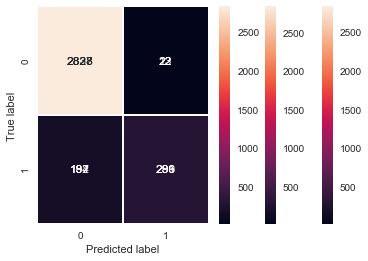

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import KFold

sns.set(style="whitegrid")

def cvTrainPredict(X,y,classifier):
    # Create an array of zeros for our predicted probabilities of churning.
    y_pred = np.zeros((len(y),1))
    y_prob = np.zeros((len(y),1))
    # Get the k-fold cross validations
    kf = KFold(len(y),n_folds=3,shuffle=True)
    # For each of the k-folds that we have just created.
    for trainIx, cvIx in kf:
        X_train, X_cv = X[trainIx], X[cvIx]
        y_train = y[trainIx]
        classifier.fit(X_train,y_train)
        # Predict class and probabilities
        y_pred[cvIx] = classifier.predict(X_cv).reshape((-1,1))
        y_prob[cvIx] = classifier.predict_proba(X_cv)[:,1].reshape((-1,1))
    return (y_pred,y_prob)

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

y_pred, y_prob = cvTrainPredict(X,y,RandomForestClassifier(n_estimators=50,max_depth=9))

print ('Accuracy: {}%'.format(100.0 * accuracy_score(y,y_pred)))
print ('Recall:   {}%'.format(100.0 * recall_score(y,y_pred)))

sns.heatmap(confusion_matrix(y,y_pred,labels=[0,1]), annot=True, fmt="d", linewidths=.5)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show ()
pass